In [1]:
#importing libraries 
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import skbio
import skbio.diversity
import skbio.stats.composition
import scipy
import pylab as pl
import statsmodels.api as sm
# import statsmodels as sm
from statsmodels.formula.api import ols
from functools import reduce
from scipy import stats


from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import model_selection
from string import ascii_letters
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV,LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold



%matplotlib inline

import arivale_data_interface as adi
# apply settings so the lib knows where the data is
adi.apply_isb_config()

#list the local snapshots
local_snapshots = adi.list_local_snapshots()
print(len(local_snapshots))
local_snapshots[0]

# ignore deprecation warnings
import warnings
warnings.filterwarnings('ignore')

98


/users/epepper/miniconda3/envs/micom/lib/python3.7/site-packages/arivale_data_interface/snapshots_interface.py:31: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  DEPRECATIONS = yaml.load(in_yaml)


In [2]:
def get_predictions(feature_name):
    
    filename = f'{feature_name}' + '/'
    #Importing csvs containing deltas and all omics
    deltas_all_omics=pd.read_csv(feature_name + '/' + feature_name + '_v_ALL_BL_omics.csv')
    #set index
    deltas_all_omics.set_index('public_client_id',inplace=True)
    deltas_all_omics.index=deltas_all_omics.index.astype('str')

    deltas_chemistries=pd.read_csv(feature_name + '/' + feature_name + '_v_chemistries.csv')
    deltas_chemistries.set_index('public_client_id',inplace=True)
    deltas_chemistries.index=deltas_chemistries.index.astype('str')

    deltas_metabolomics=pd.read_csv(feature_name + '/' + feature_name + '_v_metabolomics.csv')
    deltas_metabolomics.set_index('public_client_id',inplace=True)
    deltas_metabolomics.index=deltas_metabolomics.index.astype('str')

    deltas_proteomics=pd.read_csv(feature_name + '/' + feature_name + '_v_proteomics.csv')
    deltas_proteomics.set_index('public_client_id',inplace=True)
    deltas_proteomics.index=deltas_proteomics.index.astype('str')

    deltas_microbiome=pd.read_csv(feature_name + '/' + feature_name + '_v_microbiome.csv')
    deltas_microbiome.set_index('public_client_id',inplace=True)
    deltas_microbiome.index=deltas_microbiome.index.astype('str')

    deltas_anthro=pd.read_csv(feature_name + '/' + feature_name + '_v_anthro.csv')
    deltas_anthro.set_index('public_client_id',inplace=True)
    deltas_anthro.index=deltas_anthro.index.astype('str')

    #check shape of df
    print('deltas v all omics shape:', deltas_all_omics.shape)
    print('deltas v chemistries shape:', deltas_chemistries.shape)
    print('deltas v metabolomics shape:', deltas_metabolomics.shape)
    print('deltas v proteomics shape:', deltas_proteomics.shape)
    print('deltas v microbiome shape:', deltas_microbiome.shape)
    print('deltas v anthropomics shape:', deltas_anthro.shape)
    
    
    #################################################################################################
    #################################################################################################
    #################################################################################################

    
    #Scale and standardize omics (columns 0-last relevant column)
    X_all = deltas_all_omics[deltas_all_omics.columns[1:1880]]
    #define the dependent variable (normalized deltas)
    y_all = (deltas_all_omics[feature_name + '_Residuals'])
    #scale and standardize
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    X_allcolumns=X_all.columns
    X_all = scaler.fit_transform(X_all)
    X_all=pd.DataFrame(data=X_all,columns=X_allcolumns)

    X_chem = deltas_chemistries[deltas_chemistries.columns[1:40]]
    y_chem = (deltas_chemistries[feature_name + '_Residuals'])
    X_chemcolumns=X_chem.columns
    X_chem = scaler.fit_transform(X_chem)
    X_chem=pd.DataFrame(data=X_chem,columns=X_chemcolumns)

    X_metab = deltas_metabolomics[deltas_metabolomics.columns[1:630]]
    y_metab = (deltas_metabolomics[feature_name + '_Residuals'])
    X_metabcolumns=X_metab.columns
    X_metab = scaler.fit_transform(X_metab)
    X_metab=pd.DataFrame(data=X_metab,columns=X_metabcolumns)

    X_proteo = deltas_proteomics[deltas_proteomics.columns[1:275]]
    y_proteo = (deltas_proteomics[feature_name + '_Residuals'])
    X_proteocolumns=X_proteo.columns
    X_proteo = scaler.fit_transform(X_proteo)
    X_proteo=pd.DataFrame(data=X_proteo,columns=X_proteocolumns)

    X_microb = deltas_microbiome[deltas_microbiome.columns[1:926]]
    y_microb = (deltas_microbiome[feature_name + '_Residuals'])
    X_microbcolumns=X_microb.columns
    X_microb = scaler.fit_transform(X_microb)
    X_microb=pd.DataFrame(data=X_microb,columns=X_microbcolumns)

    X_anthro = deltas_anthro[deltas_anthro.columns[1:13]]
    y_anthro = (deltas_anthro[feature_name + '_Residuals'])
    X_anthrocolumns=X_anthro.columns
    X_anthro = scaler.fit_transform(X_anthro)
    X_anthro=pd.DataFrame(data=X_anthro,columns=X_anthrocolumns)
    
    
    #################################################################################################
    #################################################################################################
    #################################################################################################

    
    ## run cross_val_score on ridge and lasso to get out-of-sample R2 scores across 10-CV
    #This is pretty much the sklearn version doing what my code is doing in the cell below.
    #defining L2 parameters to be tested
    alphas = np.linspace(1,1000,200)

    #Defining LASSO and Ridge parameters
    #alphas are the tuning parameters tested by the algorithm, epse is a ratio of the lowest to highest alpha, provding
    #a range for where the algorithm should focus the search
    #Since the dependent variable was not scaled and standardized we also fit an intercept
    lassocv=LassoCV(eps=0.25, n_alphas=200, alphas=None, fit_intercept=False, normalize=False, precompute='auto', cv=10)
    ridgecv=RidgeCV(alphas=alphas,fit_intercept=True,normalize=False,cv=10)

    #Running 10-fold CV score function to get mean out-of-sample R2

    #All omics
    discovery_score_all = cross_val_score(lassocv,X_all,y_all,cv=10)
    print ('mean out-of-sample R2 LASSO for all omics',np.mean(discovery_score_all))
    discovery_score_ridge_all = cross_val_score(ridgecv,X_all,y_all,cv=10)
    print ('mean out-of-sample R2 Ridge for all omics',np.mean(discovery_score_ridge_all))


    #Chemistries
    discovery_score_chem = cross_val_score(lassocv,X_chem,y_chem,cv=10)
    print ('mean out-of-sample R2 LASSO for chemistries',np.mean(discovery_score_chem))
    discovery_score_ridge_chem = cross_val_score(ridgecv,X_chem,y_chem,cv=10)
    print ('mean out-of-sample R2 Ridge for chemistries',np.mean(discovery_score_ridge_chem))


    #Metabolomics
    discovery_score_metab = cross_val_score(lassocv,X_metab,y_metab,cv=10)
    print ('mean out-of-sample R2 LASSO for metabolomics',np.mean(discovery_score_metab))
    discovery_score_ridge_metab = cross_val_score(ridgecv,X_metab,y_metab,cv=10)
    print ('mean out-of-sample R2 Ridge for metabolomics',np.mean(discovery_score_ridge_metab))


    #Proteomics
    discovery_score_proteo = cross_val_score(lassocv,X_proteo,y_proteo,cv=10)
    print ('mean out-of-sample R2 LASSO for proteomics',np.mean(discovery_score_proteo))
    discovery_score_ridge_proteo = cross_val_score(ridgecv,X_proteo,y_proteo,cv=10)
    print ('mean out-of-sample R2 Ridge for proteomics',np.mean(discovery_score_ridge_proteo))


    #Microbiome
    discovery_score_microb = cross_val_score(lassocv,X_microb,y_microb,cv=10)
    print ('mean out-of-sample R2 LASSO for microbiome',np.mean(discovery_score_microb))
    discovery_score_ridge_microb = cross_val_score(ridgecv,X_microb,y_microb,cv=10)
    print ('mean out-of-sample R2 Ridge for microbiome',np.mean(discovery_score_ridge_microb))


    #Anthropomics
    discovery_score_anthro = cross_val_score(lassocv,X_anthro,y_anthro,cv=10)
    print ('mean out-of-sample R2 LASSO for anthro',np.mean(discovery_score_anthro))
    discovery_score_ridge_anthro = cross_val_score(ridgecv,X_anthro,y_anthro,cv=10)
    print ('mean out-of-sample R2 Ridge for anthro',np.mean(discovery_score_ridge_anthro))
    
    
    #################################################################################################
    #################################################################################################
    #################################################################################################

    
    #Run Cross-validation and extract Beta_coefficients for each model
    #this is pretty much replicating the analysis above, but extracting different variables along the way
    #Save predictions from each test set
    lassocv=LassoCV(eps=0.25, n_alphas=200, alphas=None, fit_intercept=False, normalize=False, precompute='auto', cv=10)


    y_all=deltas_all_omics[feature_name + '_Residuals']
    y_all=y_all.reset_index()
    y_all.drop(['public_client_id'],1,inplace=True)
    #split data into ten sets
    X_folds_all = np.array_split(X_all, 10)
    y_folds_all = np.array_split(y_all, 10)
    #create a dataframe here coefficients for each metric will be stored
    coefficients_all=pd.DataFrame(index=X_all.columns).astype('str')
    #lists for other variables extracted from the 10-fold CV
    predictions_all=[]
    alphas_all= []
    score_all= []
    #perform the 10-fold CV scheme to predict the normalized deltas from all other omics
    for k in range(10):
        X_train_all = list(X_folds_all)
        X_test_all  = X_train_all.pop(k)
        X_train_all = np.concatenate(X_train_all)
        y_train_all = list(y_folds_all)
        y_test_all  = y_train_all.pop(k)
        y_test_all=[ x[0] for x in  list(y_test_all.values)]
        y_train_all = np.concatenate(y_train_all)
        lassocv.fit(X_train_all, y_train_all)
        predictions_all.append(lassocv.predict(X_test_all).flatten())
        coef=list(lassocv.coef_)
        coefficients_all[k]=coef
        alphas_all.append(lassocv.alpha_)
        score_all.append(r2_score(y_test_all,lassocv.predict(X_test_all)))
    #print The L1 penalty for each model
    print (alphas_all)
    predictions_lasso_all=[item for sublist in predictions_all for item in sublist]
    #Checking r2 score and pearson r
    print ('mean R2 Score LASSO',np.mean(score_all))
    print ('std. deviation for R2 Score',np.std(score_all))
    print ('S.E.M',np.std(score_all)/np.sqrt(10))
    print ('observed v predicted pearson r',stats.pearsonr(deltas_all_omics[feature_name + '_Residuals'],predictions_lasso_all))
    
    
    #################################################################################################


    y_chem = deltas_chemistries[feature_name + '_Residuals']
    y_chem = y_chem.reset_index()
    y_chem.drop(['public_client_id'],1,inplace=True)
    #split data into ten sets
    X_folds_chem = np.array_split(X_chem, 10)
    y_folds_chem = np.array_split(y_chem, 10)
    #create a dataframe here coefficients for each metric will be stored
    coefficients_chem = pd.DataFrame(index = X_chem.columns).astype('str')
    #lists for other variables extracted from the 10-fold CV
    predictions_chem = []
    alphas_chem = []
    score_chem = []
    #perform the 10-fold CV scheme to predict the normalized deltas from all chemistries
    for k in range(10):
        X_train_chem = list(X_folds_chem)
        X_test_chem  = X_train_chem.pop(k)
        X_train_chem = np.concatenate(X_train_chem)
        y_train_chem = list(y_folds_chem)
        y_test_chem  = y_train_chem.pop(k)
        y_test_chem = [ x[0] for x in  list(y_test_chem.values)]
        y_train_chem = np.concatenate(y_train_chem)
        lassocv.fit(X_train_chem, y_train_chem)
        predictions_chem.append(lassocv.predict(X_test_chem).flatten())
        coef = list(lassocv.coef_)
        coefficients_chem[k] = coef
        alphas_chem.append(lassocv.alpha_)
        score_chem.append(r2_score(y_test_chem,lassocv.predict(X_test_chem)))
    #print The L1 penalty for each model
    print (alphas_chem)
    predictions_lasso_chem = [item for sublist in predictions_chem for item in sublist]
    #Checking r2 score and pearson r
    print ('mean R2 Score LASSO',np.mean(score_chem))
    print ('std. deviation for R2 Score',np.std(score_chem))
    print ('S.E.M',np.std(score_chem)/np.sqrt(10))
    print ('observed v predicted pearson r',stats.pearsonr(deltas_chemistries[feature_name + '_Residuals'],predictions_lasso_chem))
    
    
    #################################################################################################


    y_metab = deltas_metabolomics[feature_name + '_Residuals']
    y_metab = y_metab.reset_index()
    y_metab.drop(['public_client_id'],1,inplace=True)
    #split data into ten sets
    X_folds_metab = np.array_split(X_metab, 10)
    y_folds_metab = np.array_split(y_metab, 10)
    #create a dataframe here coefficients for each metric will be stored
    coefficients_metab = pd.DataFrame(index = X_metab.columns).astype('str')
    #lists for other variables extracted from the 10-fold CV
    predictions_metab = []
    alphas_metab = []
    score_metab = []
    #perform the 10-fold CV scheme to predict the normalized deltas from all metabolomics
    for k in range(10):
        X_train_metab = list(X_folds_metab)
        X_test_metab  = X_train_metab.pop(k)
        X_train_metab = np.concatenate(X_train_metab)
        y_train_metab = list(y_folds_metab)
        y_test_metab  = y_train_metab.pop(k)
        y_test_metab = [ x[0] for x in  list(y_test_metab.values)]
        y_train_metab = np.concatenate(y_train_metab)
        lassocv.fit(X_train_metab, y_train_metab)
        predictions_metab.append(lassocv.predict(X_test_metab).flatten())
        coef = list(lassocv.coef_)
        coefficients_metab[k] = coef
        alphas_metab.append(lassocv.alpha_)
        score_metab.append(r2_score(y_test_metab,lassocv.predict(X_test_metab)))
    #print The L1 penalty for each model
    print (alphas_metab)
    predictions_lasso_metab = [item for sublist in predictions_metab for item in sublist]
    #Checking r2 score and pearson r
    print ('mean R2 Score LASSO',np.mean(score_metab))
    print ('std. deviation for R2 Score',np.std(score_metab))
    print ('S.E.M',np.std(score_metab)/np.sqrt(10))
    print ('observed v predicted pearson r',stats.pearsonr(deltas_metabolomics[feature_name + '_Residuals'],predictions_lasso_metab))
    
    
    #################################################################################################


    y_proteo = deltas_proteomics[feature_name + '_Residuals']
    y_proteo = y_proteo.reset_index()
    y_proteo.drop(['public_client_id'],1,inplace=True)
    #split data into ten sets
    X_folds_proteo = np.array_split(X_proteo, 10)
    y_folds_proteo = np.array_split(y_proteo, 10)
    #create a dataframe here coefficients for each metric will be stored
    coefficients_proteo = pd.DataFrame(index = X_proteo.columns).astype('str')
    #lists for other variables extracted from the 10-fold CV
    predictions_proteo = []
    alphas_proteo = []
    score_proteo = []
    #perform the 10-fold CV scheme to predict the normalized deltas from all proteomics
    for k in range(10):
        X_train_proteo = list(X_folds_proteo)
        X_test_proteo  = X_train_proteo.pop(k)
        X_train_proteo = np.concatenate(X_train_proteo)
        y_train_proteo = list(y_folds_proteo)
        y_test_proteo  = y_train_proteo.pop(k)
        y_test_proteo = [ x[0] for x in  list(y_test_proteo.values)]
        y_train_proteo = np.concatenate(y_train_proteo)
        lassocv.fit(X_train_proteo, y_train_proteo)
        predictions_proteo.append(lassocv.predict(X_test_proteo).flatten())
        coef = list(lassocv.coef_)
        coefficients_proteo[k] = coef
        alphas_proteo.append(lassocv.alpha_)
        score_proteo.append(r2_score(y_test_proteo,lassocv.predict(X_test_proteo)))
    #print The L1 penalty for each model
    print (alphas_proteo)
    predictions_lasso_proteo = [item for sublist in predictions_proteo for item in sublist]
    #Checking r2 score and pearson r
    print ('mean R2 Score LASSO',np.mean(score_proteo))
    print ('std. deviation for R2 Score',np.std(score_proteo))
    print ('S.E.M',np.std(score_proteo)/np.sqrt(10))
    print ('observed v predicted pearson r',stats.pearsonr(deltas_proteomics[feature_name + '_Residuals'],predictions_lasso_proteo))
    
    
    #################################################################################################


    y_microb = deltas_microbiome[feature_name + '_Residuals']
    y_microb = y_microb.reset_index()
    y_microb.drop(['public_client_id'],1,inplace=True)
    #split data into ten sets
    X_folds_microb = np.array_split(X_microb, 10)
    y_folds_microb = np.array_split(y_microb, 10)
    #create a dataframe here coefficients for each metric will be stored
    coefficients_microb = pd.DataFrame(index = X_microb.columns).astype('str')
    #lists for other variables extracted from the 10-fold CV
    predictions_microb = []
    alphas_microb = []
    score_microb = []
    #perform the 10-fold CV scheme to predict the normalized deltas from all microbiome metrics
    for k in range(10):
        X_train_microb = list(X_folds_microb)
        X_test_microb  = X_train_microb.pop(k)
        X_train_microb = np.concatenate(X_train_microb)
        y_train_microb = list(y_folds_microb)
        y_test_microb  = y_train_microb.pop(k)
        y_test_microb = [ x[0] for x in  list(y_test_microb.values)]
        y_train_microb = np.concatenate(y_train_microb)
        lassocv.fit(X_train_microb, y_train_microb)
        predictions_microb.append(lassocv.predict(X_test_microb).flatten())
        coef = list(lassocv.coef_)
        coefficients_microb[k] = coef
        alphas_microb.append(lassocv.alpha_)
        score_microb.append(r2_score(y_test_microb,lassocv.predict(X_test_microb)))
    #print The L1 penalty for each model
    print (alphas_microb)
    predictions_lasso_microb = [item for sublist in predictions_microb for item in sublist]
    #Checking r2 score and pearson r
    print ('mean R2 Score LASSO',np.mean(score_microb))
    print ('std. deviation for R2 Score',np.std(score_microb))
    print ('S.E.M',np.std(score_microb)/np.sqrt(10))
    print ('observed v predicted pearson r',stats.pearsonr(deltas_microbiome[feature_name + '_Residuals'],predictions_lasso_microb))
    
    
    #################################################################################################


    y_anthro = deltas_anthro[feature_name + '_Residuals']
    y_anthro = y_anthro.reset_index()
    y_anthro.drop(['public_client_id'],1,inplace=True)
    #split data into ten sets
    X_folds_anthro = np.array_split(X_anthro, 10)
    y_folds_anthro = np.array_split(y_anthro, 10)
    #create a dataframe here coefficients for each metric will be stored
    coefficients_anthro = pd.DataFrame(index = X_anthro.columns).astype('str')
    #lists for other variables extracted from the 10-fold CV
    predictions_anthro = []
    alphas_anthro = []
    score_anthro = []
    #perform the 10-fold CV scheme to predict the normalized deltas from all anthropomics
    for k in range(10):
        X_train_anthro = list(X_folds_anthro)
        X_test_anthro  = X_train_anthro.pop(k)
        X_train_anthro = np.concatenate(X_train_anthro)
        y_train_anthro = list(y_folds_anthro)
        y_test_anthro  = y_train_anthro.pop(k)
        y_test_anthro = [ x[0] for x in  list(y_test_anthro.values)]
        y_train_anthro = np.concatenate(y_train_anthro)
        lassocv.fit(X_train_anthro, y_train_anthro)
        predictions_anthro.append(lassocv.predict(X_test_anthro).flatten())
        coef = list(lassocv.coef_)
        coefficients_anthro[k] = coef
        alphas_anthro.append(lassocv.alpha_)
        score_anthro.append(r2_score(y_test_anthro,lassocv.predict(X_test_anthro)))
    #print The L1 penalty for each model
    print (alphas_anthro)
    predictions_lasso_anthro = [item for sublist in predictions_anthro for item in sublist]
    #Checking r2 score and pearson r
    print ('mean R2 Score LASSO',np.mean(score_anthro))
    print ('std. deviation for R2 Score',np.std(score_anthro))
    print ('S.E.M',np.std(score_anthro)/np.sqrt(10))
    print ('observed v predicted pearson r',stats.pearsonr(deltas_anthro[feature_name + '_Residuals'],predictions_lasso_anthro))
    
    
    #################################################################################################
    #################################################################################################
    #################################################################################################
    
    
    print('all omics scores are:', score_all)
    print('chemistry scores are:', score_chem)
    print('metabolome scores are:', score_metab)
    print('proteome scores are:', score_proteo)
    print('microbiome scores are:', score_microb)
    print('anthropomics scores are:', score_anthro)
    
    
    #################################################################################################
    #################################################################################################
    #################################################################################################
    
    
    #generate dataframe with out-of-sample predictions for each person
    #All omics
    predictions_all = pd.DataFrame(index = deltas_all_omics.index)
    predictions_all['predictions'] = predictions_lasso_all
    predictions_all[feature_name + '_Residuals']=deltas_all_omics[feature_name + '_Residuals']
    # predictions_all.to_csv(filename + f'{feature_name}_predictions_all_omics.csv')


    #Chemistries
    predictions_chem = pd.DataFrame(index = deltas_chemistries.index)
    predictions_chem['predictions'] = predictions_lasso_chem
    predictions_chem[feature_name + '_Residuals']=deltas_chemistries[feature_name + '_Residuals']
    # predictions_chem.to_csv(filename + f'{feature_name}_predictions_chemistries.csv')


    #Metabolomics
    predictions_metab = pd.DataFrame(index = deltas_metabolomics.index)
    predictions_metab['predictions'] = predictions_lasso_metab
    predictions_metab[feature_name + '_Residuals']=deltas_metabolomics[feature_name + '_Residuals']
    # predictions_metab.to_csv(filename + f'{feature_name}_predictions_metabolomics.csv')


    #Proteomics
    predictions_proteo = pd.DataFrame(index = deltas_proteomics.index)
    predictions_proteo['predictions'] = predictions_lasso_proteo
    predictions_proteo[feature_name + '_Residuals']=deltas_proteomics[feature_name + '_Residuals']
    # predictions_proteo.to_csv(filename + f'{feature_name}_predictions_proteomics.csv')
    
    
    #Microbiome
    predictions_microb = pd.DataFrame(index = deltas_microbiome.index)
    predictions_microb['predictions'] = predictions_lasso_microb
    predictions_microb[feature_name + '_Residuals']=deltas_microbiome[feature_name + '_Residuals']
    # predictions_microb.to_csv(filename + f'{feature_name}_predictions_microbiome.csv')


    #Anthropomics
    predictions_anthro = pd.DataFrame(index = deltas_anthro.index)
    predictions_anthro['predictions'] = predictions_lasso_anthro
    predictions_anthro[feature_name + '_Residuals']=deltas_anthro[feature_name + '_Residuals']
    # predictions_anthro.to_csv(filename + f'{feature_name}_predictions_anthro.csv')
    
    
    #################################################################################################
    #################################################################################################
    #################################################################################################
    
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 20), dpi=100)

    sns.set(font_scale=0.50,context='poster',font='Arial',style='white')

    plt.setp(axes[-1, :], xlabel='Predicted Residuals')
    plt.setp(axes[:, 0], ylabel='Observed Residuals')
    plt.rc('axes', labelsize=14)
    
    x_bound = np.min(deltas_all_omics[feature_name + '_Residuals'])
    y_bound = np.max(deltas_all_omics[feature_name + '_Residuals'])
    
    label_all = 'lasso score = ' + np.mean(discovery_score_all).astype(str) + '\n' + 'ridge score = ' + np.mean(discovery_score_ridge_all).astype(str)
    
    label_chem = 'lasso score = ' + np.mean(discovery_score_chem).astype(str) + '\n' + 'ridge score = ' + np.mean(discovery_score_ridge_chem).astype(str)
    
    label_metab = 'lasso score = ' + np.mean(discovery_score_metab).astype(str) + '\n' + 'ridge score = ' + np.mean(discovery_score_ridge_metab).astype(str)
    
    label_proteo = 'lasso score = ' + np.mean(discovery_score_proteo).astype(str) + '\n' + 'ridge score = ' + np.mean(discovery_score_ridge_proteo).astype(str)
    
    label_microb = 'lasso score = ' + np.mean(discovery_score_microb).astype(str) + '\n' + 'ridge score = ' + np.mean(discovery_score_ridge_microb).astype(str)
    
    label_anthro = 'lasso score = ' + np.mean(discovery_score_anthro).astype(str) + '\n' + 'ridge score = ' + np.mean(discovery_score_ridge_anthro).astype(str)
    


    axes[0, 0].scatter(predictions_lasso_all, deltas_all_omics[feature_name + '_Residuals'], s=80, color='r', alpha=0.65, linewidth=1, edgecolors='black')
    axes[0, 0].set_title('All Omics')
    axes[0, 0].plot(y_all, y_all)
    axes[0, 0].text(x_bound, y_bound, label_all, horizontalalignment='left', verticalalignment='top')

    axes[0, 1].scatter(predictions_lasso_chem, deltas_chemistries[feature_name + '_Residuals'], s=80, color='r', alpha=0.65, linewidth=1, edgecolors='black')
    axes[0, 1].set_title('Chemistries')
    axes[0, 1].plot(y_chem, y_chem)
    axes[0, 1].text(x_bound, y_bound, label_chem, horizontalalignment='left', verticalalignment='top')

    axes[1, 0].scatter(predictions_lasso_metab, deltas_metabolomics[feature_name + '_Residuals'], s=80, color='r', alpha=0.65, linewidth=1, edgecolors='black')
    axes[1, 0].set_title('Metabolomics')
    axes[1, 0].plot(y_metab, y_metab)
    axes[1, 0].text(x_bound, y_bound, label_metab, horizontalalignment='left', verticalalignment='top')

    axes[1, 1].scatter(predictions_lasso_proteo, deltas_proteomics[feature_name + '_Residuals'], s=80, color='r', alpha=0.65, linewidth=1, edgecolors='black')
    axes[1, 1].set_title('Proteomics')
    axes[1, 1].plot(y_proteo, y_proteo)
    axes[1, 1].text(x_bound, y_bound, label_proteo, horizontalalignment='left', verticalalignment='top')

    axes[2, 0].scatter(predictions_lasso_microb, deltas_microbiome[feature_name + '_Residuals'], s=80, color='r', alpha=0.65, linewidth=1, edgecolors='black')
    axes[2, 0].set_title('Microbiome')
    axes[2, 0].plot(y_microb, y_microb)
    axes[2, 0].text(x_bound, y_bound, label_microb, horizontalalignment='left', verticalalignment='top')

    axes[2, 1].scatter(predictions_lasso_anthro, deltas_anthro[feature_name + '_Residuals'], s=80, color='r', alpha=0.65, linewidth=1, edgecolors='black')
    axes[2, 1].set_title('Anthropomorphic')
    axes[2, 1].plot(y_anthro, y_anthro)
    axes[2, 1].text(x_bound, y_bound, label_anthro, horizontalalignment='left', verticalalignment='top')

    plt.savefig(filename + f'{feature_name}_lasso_predictions')
    
    
    #################################################################################################
    #################################################################################################
    #################################################################################################
    
    
    #Identifying all features with non-zero Beta Coefficients
    
    # All omics
    for x in coefficients_all.index.tolist():
        if (coefficients_all.loc[x] == 0.0).sum()==10:
            coefficients_all.drop([x],inplace=True)
    print (coefficients_all.shape)
    #calculating mean beta-coefficient for each feature and counting no. of times each feature had a 0 beta-coefficient.
    means=[]
    std=[]
    zeroes=[]
    for x in coefficients_all.index.tolist():
        means.append((np.mean(coefficients_all.loc[x])))
        std.append((np.std(coefficients_all.loc[x])))
        zeroes.append((coefficients_all.loc[x] == 0.0).astype(int).sum())
    coefficients_all['mean']=means
    coefficients_all['std_dev']=std
    coefficients_all['zeroes']=zeroes
    #save table as csv
    coefficients_all.to_csv(filename + f'{feature_name}_all_40_coefs.csv')
    coefficients_all.sort_values(by='mean',ascending=False).head()
    
    #################################################################################################

    # Chemistries
    for x in coefficients_chem.index.tolist():
        if (coefficients_chem.loc[x] == 0.0).sum()==10:
            coefficients_chem.drop([x],inplace=True)
    print (coefficients_chem.shape)
    #calculating mean beta-coefficient for each feature and counting no. of times each feature had a 0 beta-coefficient.
    means=[]
    std=[]
    zeroes=[]
    for x in coefficients_chem.index.tolist():
        means.append((np.mean(coefficients_chem.loc[x])))
        std.append((np.std(coefficients_chem.loc[x])))
        zeroes.append((coefficients_chem.loc[x] == 0.0).astype(int).sum())
    coefficients_chem['mean']=means
    coefficients_chem['std_dev']=std
    coefficients_chem['zeroes']=zeroes
    #save table as csv
    coefficients_chem.to_csv(filename + f'{feature_name}_chemistries_40_coefs.csv')
    coefficients_chem.sort_values(by='mean',ascending=False).head()
    
    #################################################################################################

    # Metabolomics
    for x in coefficients_metab.index.tolist():
        if (coefficients_metab.loc[x] == 0.0).sum()==10:
            coefficients_metab.drop([x],inplace=True)
    print (coefficients_metab.shape)
    #calculating mean beta-coefficient for each feature and counting no. of times each feature had a 0 beta-coefficient.
    means=[]
    std=[]
    zeroes=[]
    for x in coefficients_metab.index.tolist():
        means.append((np.mean(coefficients_metab.loc[x])))
        std.append((np.std(coefficients_metab.loc[x])))
        zeroes.append((coefficients_metab.loc[x] == 0.0).astype(int).sum())
    coefficients_metab['mean']=means
    coefficients_metab['std_dev']=std
    coefficients_metab['zeroes']=zeroes
    #save table as csv
    coefficients_metab.to_csv(filename + f'{feature_name}_metabolomics_40_coefs.csv')
    coefficients_metab.sort_values(by='mean',ascending=False).head()
    
    #################################################################################################

    # Proteomics
    for x in coefficients_proteo.index.tolist():
        if (coefficients_proteo.loc[x] == 0.0).sum()==10:
            coefficients_proteo.drop([x],inplace=True)
    print (coefficients_proteo.shape)
    #calculating mean beta-coefficient for each feature and counting no. of times each feature had a 0 beta-coefficient.
    means=[]
    std=[]
    zeroes=[]
    for x in coefficients_proteo.index.tolist():
        means.append((np.mean(coefficients_proteo.loc[x])))
        std.append((np.std(coefficients_proteo.loc[x])))
        zeroes.append((coefficients_proteo.loc[x] == 0.0).astype(int).sum())
    coefficients_proteo['mean']=means
    coefficients_proteo['std_dev']=std
    coefficients_proteo['zeroes']=zeroes
    #save table as csv
    coefficients_proteo.to_csv(filename + f'{feature_name}_proteomics_40_coefs.csv')
    coefficients_proteo.sort_values(by='mean',ascending=False).head()
    
    #################################################################################################

    # Microbiome
    for x in coefficients_microb.index.tolist():
        if (coefficients_microb.loc[x] == 0.0).sum()==10:
            coefficients_microb.drop([x],inplace=True)
    print (coefficients_microb.shape)
    #calculating mean beta-coefficient for each feature and counting no. of times each feature had a 0 beta-coefficient.
    means=[]
    std=[]
    zeroes=[]
    for x in coefficients_microb.index.tolist():
        means.append((np.mean(coefficients_microb.loc[x])))
        std.append((np.std(coefficients_microb.loc[x])))
        zeroes.append((coefficients_microb.loc[x] == 0.0).astype(int).sum())
    coefficients_microb['mean']=means
    coefficients_microb['std_dev']=std
    coefficients_microb['zeroes']=zeroes
    #save table as csv
    coefficients_microb.to_csv(filename + f'{feature_name}_microbiome_40_coefs.csv')
    coefficients_microb.sort_values(by='mean',ascending=False).head()
    
    #################################################################################################

    # Anthropomorphic
    for x in coefficients_anthro.index.tolist():
        if (coefficients_anthro.loc[x] == 0.0).sum()==10:
            coefficients_anthro.drop([x],inplace=True)
    print (coefficients_anthro.shape)
    #calculating mean beta-coefficient for each feature and counting no. of times each feature had a 0 beta-coefficient.
    means=[]
    std=[]
    zeroes=[]
    for x in coefficients_anthro.index.tolist():
        means.append((np.mean(coefficients_anthro.loc[x])))
        std.append((np.std(coefficients_anthro.loc[x])))
        zeroes.append((coefficients_anthro.loc[x] == 0.0).astype(int).sum())
    coefficients_anthro['mean']=means
    coefficients_anthro['std_dev']=std
    coefficients_anthro['zeroes']=zeroes
    #save table as csv
    coefficients_anthro.to_csv(filename + f'{feature_name}_anthro_40_coefs.csv')
    coefficients_anthro.sort_values(by='mean',ascending=False).head()

deltas v all omics shape: (352, 1890)
deltas v chemistries shape: (473, 50)
deltas v metabolomics shape: (377, 640)
deltas v proteomics shape: (423, 285)
deltas v microbiome shape: (472, 936)
deltas v anthropomics shape: (410, 23)
mean out-of-sample R2 LASSO for all omics 0.05076865343091179
mean out-of-sample R2 Ridge for all omics -0.1258190737334931
mean out-of-sample R2 LASSO for chemistries -0.008030495032522478
mean out-of-sample R2 Ridge for chemistries 0.0191249256081928
mean out-of-sample R2 LASSO for metabolomics -0.029015996492550954
mean out-of-sample R2 Ridge for metabolomics -0.08152825144162626
mean out-of-sample R2 LASSO for proteomics -0.019744888842929475
mean out-of-sample R2 Ridge for proteomics -0.047564241973219776
mean out-of-sample R2 LASSO for microbiome -0.04330483139759452
mean out-of-sample R2 Ridge for microbiome -0.10375095461021966
mean out-of-sample R2 LASSO for anthro 0.04275331179760765
mean out-of-sample R2 Ridge for anthro 0.22874395044107584
[0.0763

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


[0.03983617652393966, 0.038592981207312686, 0.041121498193836405, 0.03756926265616189, 0.035208182071096814, 0.03543727048546812, 0.039545802206766, 0.03766410752896739, 0.03901856976451078, 0.04204939869567431]
mean R2 Score LASSO 0.04275331179760765
std. deviation for R2 Score 0.08141437799192576
S.E.M 0.025745486874037098
observed v predicted pearson r (0.2669185876855631, 4.063451537051436e-08)
all omics scores are: [-0.03305378111135848, 0.03842341108558056, 0.017842565899805707, 0.11124370675573292, 0.03396965986436051, 0.19139185113636326, -0.00026926137134863914, 0.15276526710824612, 0.07375441398971438, -0.07838129904797841]
chemistry scores are: [-0.005309847406720136, -0.03376906571410587, -0.03602938975258718, 0.012873509704993569, 0.04231692693955058, 0.026101682074847976, -0.0017919450793657532, 0.00722762909259167, -0.05798558043057733, -0.0339388697538523]
metabolome scores are: [0.008637289932395875, -0.03880568606707424, -0.09598086543458861, 0.031023014578821395, -0.

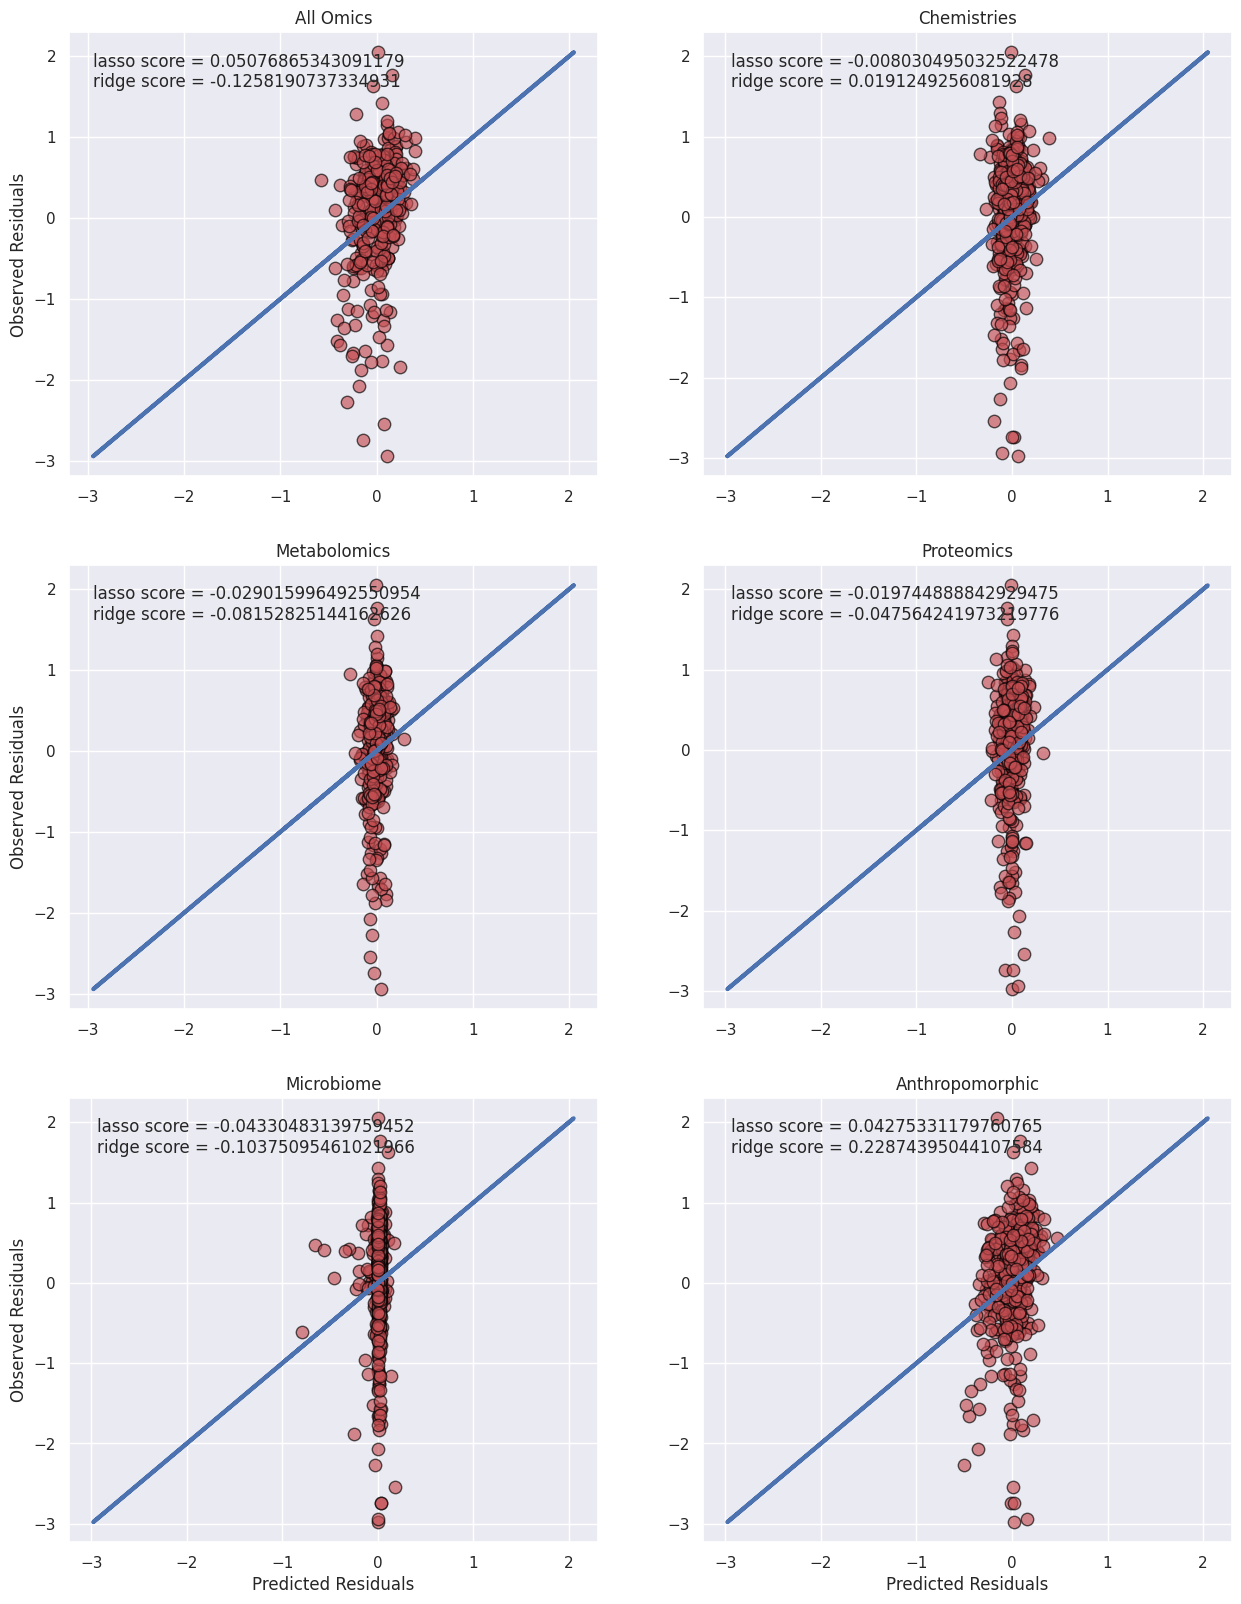

In [3]:
# to run the function, use get_predicitons('feature name') where feature name is the name you gave the feature (same as the name of
# the directory you save all of the results in)


# get_predictions('red_cell_count')
# get_predictions('diastolic')

# switched to excluding features with less than 10% reported measurements
# and to using median imputation instead of filling in zeros

# get_predictions('homocysteine')

# added the cross validations scores to the plots
# changed exclusion to remove features with less than 90% reported measurements 

# get_predictions('triglycerides')
# get_predictions('systolic')
# get_predictions('cholesterol')
# get_predictions('ldl-c')
# get_predictions('hdl-c')
# get_predictions('ldl_particle_number')
# get_predictions('hdl_particle_number')
# get_predictions('omega6-3_ratio')
# get_predictions('t-hdl_ratio')
# get_predictions('chao1_50k')
# get_predictions('shannon_100k')

# removed outliers that were > 3 standard deviations away from the mean

# get_predictions('hba1c')
get_predictions('weight')